In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import kaggle
import zipfile
from IPython.display import Markdown

In [185]:
# !kaggle datasets download -d navjotkaushal/coffee-sales-dataset

In [186]:
# with zipfile.ZipFile('coffee-sales-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

In [187]:
coffee_df = pd.read_csv('data/Coffe_sales.csv')

# ☕ Analysis goals

### Analysis Objectives

1. **Explore sales patterns over time**  
   - Examine coffee sales by hour, day of the week, and month.  
   - Identify the busiest hours and sales distribution across the day.

2. **Identify outliers in sales**  
   - Detect unusual sales days or transactions (e.g., very high or low sales).  
   - Investigate whether these outliers correspond to holidays or special events.

3. **Analyze sales by coffee type and time of day**  
   - Determine which coffee types sell the most during Morning, Afternoon, Evening, and Night.  
   - Calculate percentage share of each coffee type per time of day.

4. **Examine monthly revenue trends**  
   - Aggregate revenue per month (considering the year) to detect seasonality.  
   - Visualize trends and highlight months with exceptionally high or low revenue.

5. **Investigate potential link to U.S. holidays**  
   - Check if sales patterns align with major U.S. holidays (e.g., July 4th, Labor Day, Thanksgiving).  
   - Assess whether the data could plausibly come from the U.S. based on holiday effects.

# ☕ 1: General Data Overview

In [188]:
coffee_df.sample(5)

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
2269,7,card,35.76,Latte,Morning,Tue,Nov,2,11,2024-11-19,07:52:13.414000
518,17,card,37.72,Cappuccino,Night,Sun,May,7,5,2024-05-26,17:19:15.521000
1399,15,card,32.82,Latte,Afternoon,Sat,Sep,6,9,2024-09-07,15:55:08.533000
1419,9,card,32.82,Latte,Morning,Mon,Sep,1,9,2024-09-09,09:59:10.750000
309,15,card,37.72,Latte,Afternoon,Thu,Apr,4,4,2024-04-25,15:18:26.971000


### Data Frame condition

In [189]:
info_df = pd.DataFrame({
    'Column': coffee_df.columns,
    'Data Type': coffee_df.dtypes.values,
    'Missing Values': coffee_df.isna().sum().values,
    'Unique Values': coffee_df.nunique().values
})
info_df

,Column,Data Type,Missing Values,Unique Values
0,hour_of_day,int64,0,17
1,cash_type,object,0,1
2,money,float64,0,13
3,coffee_name,object,0,8
4,Time_of_Day,object,0,3
5,Weekday,object,0,7
6,Month_name,object,0,12
7,Weekdaysort,int64,0,7
8,Monthsort,int64,0,12
9,Date,object,0,381


In [190]:
Markdown(f' #### Total Unique Values: **{coffee_df.nunique().sum()}**')

 #### Total Unique Values: **4008**

In [191]:
Markdown(f' #### Total Missing Values: {coffee_df.isna().sum().sum()}')

 #### Total Missing Values: 0

In [192]:
Markdown(f' #### Total Number of Duplicates: {coffee_df.duplicated().sum()}')

 #### Total Number of Duplicates: 0

In [193]:
Markdown(f' #### As we can see, data preprocessing is needed for date and time fields.')

 #### As we can see, data preprocessing is needed for date and time fields.

Changes made to the DataFrame:

Added a new time-of-day category: "Evening" to gain better insights into sales

Added a DateTime column as a pandas datetime

Converted the Time column format to Python datetime

### The data does not require any cleaning.

In [194]:
# mask_evening = (coffee_df["hour_of_day"] >= 18) & (coffee_df["hour_of_day"] < 22)
# coffee_df.loc[mask_evening, "Time_of_Day"] = "Evening"

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 21:
        return "Evening"
    else:
        return "Night"

coffee_df["Time_of_Day"] = coffee_df["hour_of_day"].map(get_time_of_day)

In [195]:
coffee_df['Time'] = coffee_df['Time'].str[:8]
coffee_df['Date Time'] = coffee_df['Date'].astype(str) + ' ' + coffee_df['Time']

In [196]:

coffee_df['Date Time'] = pd.to_datetime(coffee_df['Date Time'])
# coffee_df["Time"] = pd.to_datetime(coffee_df["Time"], format="%H:%M:%S", errors="coerce")
# coffee_df["Time"] = pd.to_datetime(coffee_df["Time"], format="%H:%M:%S").dt.time
coffee_df["Time"] = coffee_df["Date Time"].dt.time

In [197]:
star_date = coffee_df['Date Time'].min().date()
end_date = coffee_df['Date Time'].max().date()

Markdown(f' #### The data covers the period from {star_date} do {end_date}')

 #### The data covers the period from 2024-03-01 do 2025-03-23

In [198]:
latest_time = coffee_df["Time"].max()
earliest_coffee = coffee_df["Time"].min()
Markdown(f' #### The earliest coffee purchase was at {earliest_coffee}, and the latest coffee purchase was at {latest_time}')

 #### The earliest coffee purchase was at 06:50:04, and the latest coffee purchase was at 22:59:18

###  Data Frame condition after the changes introduced

In [199]:
highlight_cols = ['Date Time', 'Time', 'Time_of_Day']

def highlight_column(val):
    if val in highlight_cols:
        return 'font-weight: bold; color: #C69C6D'
    return ''

info_df = pd.DataFrame({
    'Column': coffee_df.columns,
    'Data Type': coffee_df.dtypes.values,
    'Missing Values': coffee_df.isna().sum().values,
    'Unique Values': coffee_df.nunique().values
})

info_df.style.map(highlight_column, subset=['Column'])


,Column,Data Type,Missing Values,Unique Values
0,hour_of_day,int64,0,17
1,cash_type,object,0,1
2,money,float64,0,13
3,coffee_name,object,0,8
4,Time_of_Day,object,0,4
5,Weekday,object,0,7
6,Month_name,object,0,12
7,Weekdaysort,int64,0,7
8,Monthsort,int64,0,12
9,Date,object,0,381


Statistical summary of the dataset:

In [200]:
coffee_df.describe().T

,count,mean,min,25%,50%,75%,max,std
hour_of_day,3547.0,14.185791,6.0,10.0,14.0,18.0,22.0,4.23401
money,3547.0,31.645216,18.12,27.92,32.82,35.76,38.7,4.877754
Weekdaysort,3547.0,3.845785,1.0,2.0,4.0,6.0,7.0,1.971501
Monthsort,3547.0,6.453905,1.0,3.0,7.0,10.0,12.0,3.500754
Date Time,3547,2024-10-05 08:15:19.208062976,2024-03-01 10:15:50,2024-07-18 00:07:36,2024-10-10 09:51:44,2025-01-11 11:46:11.500000,2025-03-23 18:11:38,NaN


# ☕ 2: Analysis of Individual Variables

### Total Sales of Each Coffee Type Over the Entire Period

In [201]:
coffee_counts = coffee_df['coffee_name'].value_counts().reset_index()

# change columns names
coffee_counts.columns = ['Coffee Type', 'Quantity Sold']
coffee_counts.to_string(index=False)
coffee_counts.style.bar(subset=['Quantity Sold'], color='#C69C6D')

,Coffee Type,Quantity Sold
0,Americano with Milk,809
1,Latte,757
2,Americano,564
3,Cappuccino,486
4,Cortado,287
5,Hot Chocolate,276
6,Cocoa,239
7,Espresso,129


### Profit from Each Coffee Type Over the Entire Period

In [202]:
coffee_counts_money = coffee_df.groupby('coffee_name')['money'].sum().reset_index()

coffee_counts_money.columns = ['Coffee Type', 'Total Profit']
coffee_counts_money['Total Profit'] = coffee_counts_money['Total Profit']
coffee_counts_money = coffee_counts_money.sort_values(by='Total Profit', ascending=False)

coffee_counts_money.style.bar(subset=['Total Profit'], color='#4CAF50').format({'Łączny zysk': '{:.2f}'})

,Coffee Type,Total Profit
7,Latte,26875.300000
1,Americano with Milk,24751.120000
2,Cappuccino,17439.140000
0,Americano,14650.260000
6,Hot Chocolate,9933.460000
3,Cocoa,8521.160000
4,Cortado,7384.860000
5,Espresso,2690.280000


### Total Coffee Sales per Month

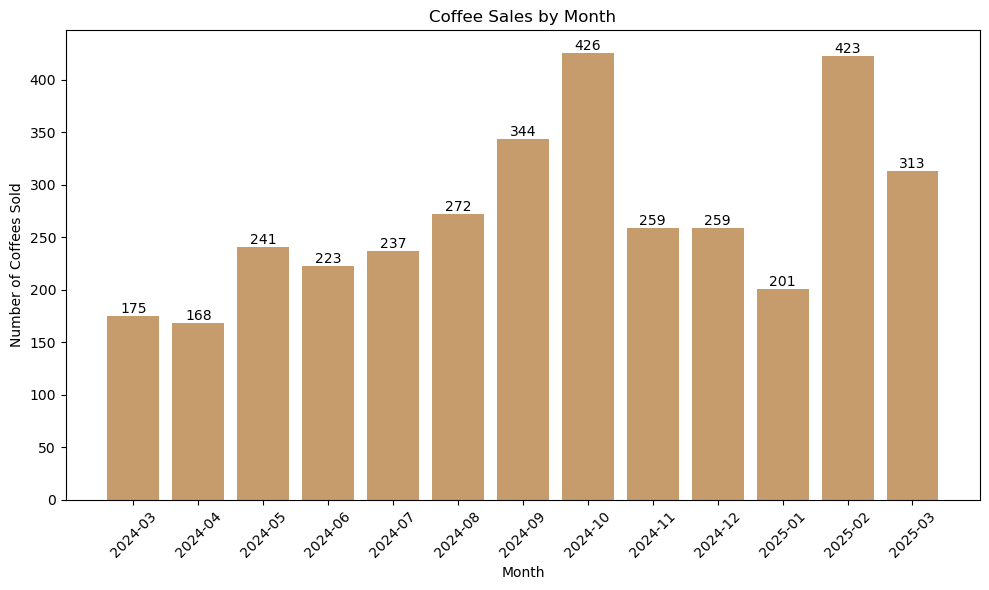

In [203]:
# Filter data between March 1, 2024 and March 23, 2025
mask = (coffee_df['Date Time'] >= '2024-03-01') & (coffee_df['Date Time'] <= '2025-03-23')
filtered_data = coffee_df.loc[mask].copy()

# Add a column for Year and Month
filtered_data['YearMonth'] = filtered_data['Date Time'].dt.to_period('M')

# Group data by month and count the number of coffees sold
monthly_sales = filtered_data.groupby('YearMonth')['coffee_name'].count().reset_index()

# Rename columns
monthly_sales.columns = ['Month', 'Number of Coffees Sold']
monthly_sales.style.bar(subset=['Number of Coffees Sold'], color='#4CAF50')

# Plot the monthly coffee sales
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_sales['Month'].astype(str), monthly_sales['Number of Coffees Sold'], color='#C69C6D')
plt.title('Coffee Sales by Month')
plt.xlabel('Month')
plt.ylabel('Number of Coffees Sold')
plt.xticks(rotation=45)

# Add labels on top of each bar with the number of coffees sold
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()  # Adjusts the plot to fit nicely
plt.show()


In [204]:
march_24_coffee_sells_mask = (coffee_df['Date Time'] >= '2024-03-01') & (coffee_df['Date Time'] < '2024-04-01')
march_24_coffees = coffee_df.loc[march_24_coffee_sells_mask]
march_24_coffee_sells = march_24_coffees['coffee_name'].value_counts().sum()
march_24_coffee_sells


march_25_coffee_sells_mask = (coffee_df['Date Time'] >= '2025-03-01') & (coffee_df['Date Time'] <= '2025-03-23')
march_25_coffees = coffee_df.loc[march_25_coffee_sells_mask]
march_25_coffee_sells = march_25_coffees['coffee_name'].value_counts().sum()
march_25_coffee_sells

marchs_difference = march_25_coffee_sells - march_24_coffee_sells

Markdown(f'''#### We can only see that March 2025 has the highest coffee consumption rate, even though the data for March 2025 does not include the last 8 days.  
#### In March 2025, {march_25_coffee_sells} coffees were sold, while in March 2024, {march_24_coffee_sells} were sold, which is {marchs_difference} more.  
#### Based on the data, one could conclude that the overall trend in consumption might have been increasing, but the data is incomplete.  
#### We also do not have data for January and February 2025.''')


#### We can only see that March 2025 has the highest coffee consumption rate, even though the data for March 2025 does not include the last 8 days.  
#### In March 2025, 313 coffees were sold, while in March 2024, 175 were sold, which is 138 more.  
#### Based on the data, one could conclude that the overall trend in consumption might have been increasing, but the data is incomplete.  
#### We also do not have data for January and February 2025.

# Total Coffee Sales by Day of the Week

In [205]:
daily_coffee_counts = coffee_df.groupby('Weekdaysort')['coffee_name'].count().reset_index()

# Setting column names for readability
daily_coffee_counts.columns = ['Weekdaysort', 'Number of Coffees Sold']
daily_coffee_counts = daily_coffee_counts.sort_values(by='Weekdaysort', ascending=True)
daily_coffee_counts.style.bar(subset=['Number of Coffees Sold'], color='#C69C6D')

,Weekdaysort,Number of Coffees Sold
0,1,544
1,2,572
2,3,500
3,4,510
4,5,532
5,6,470
6,7,419


#### As we can see, the largest drop in coffee purchases occurs on Saturday and Sunday, followed by an increase on Monday and Tuesday at the start of the week. After that, there is a slight decline, with an upward trend toward Friday.

### Coffee sales by time of day

In [206]:
daily_coffee_counts = coffee_df.groupby('Time_of_Day')['coffee_name'].count().reset_index()

# Setting column names for readability
daily_coffee_counts.columns = ['Time_of_Day', 'Coffee Sales by Time of Day']
daily_coffee_counts = daily_coffee_counts.sort_values(by='Time_of_Day', ascending=True)
daily_coffee_counts.style.bar(subset=['Coffee Sales by Time of Day'], color='#C69C6D')

,Time_of_Day,Coffee Sales by Time of Day
0,Afternoon,1442
1,Evening,616
2,Morning,1181
3,Night,308


In [207]:
sales_per_hour = coffee_df["hour_of_day"].value_counts().sort_index()

# hour with max sels
busiest_hour = sales_per_hour.idxmax()
max_sales = sales_per_hour.max()

Markdown(f"#### The highest sales occurred at {busiest_hour}:00 ({max_sales} transactions).")

#### The highest sales occurred at 10:00 (328 transactions).

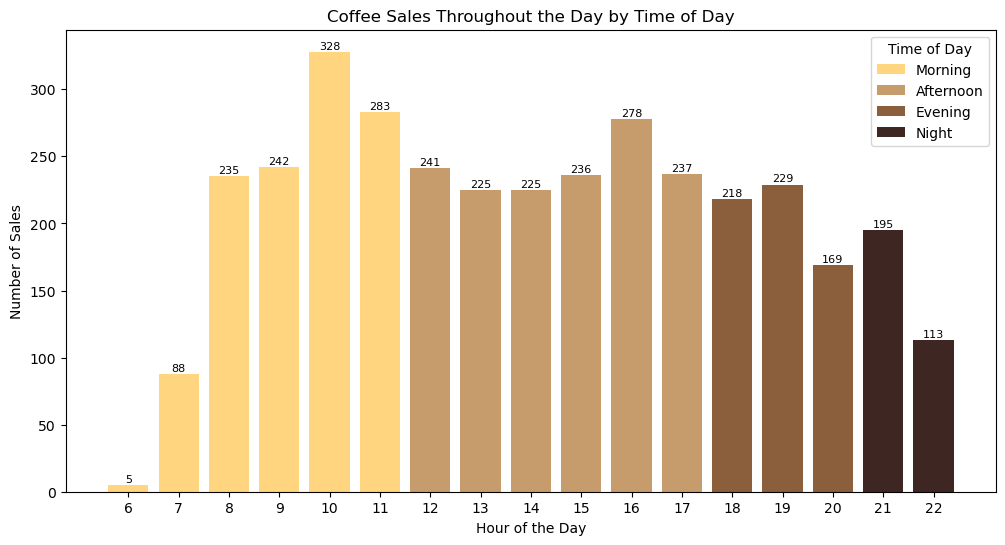

In [208]:
# Define a color map for different times of day
colors_map = {
    "Morning": "#FFD580",    # Light orange
    "Afternoon": "#C69C6D",  # Coffee with milk
    "Evening": "#8B5E3C",    # Darker brown
    "Night": "#3E2723"        # Very dark brown
}

# 3️⃣ Assign a color to each hour based on Time_of_Day
hour_to_period = coffee_df.drop_duplicates("hour_of_day")[["hour_of_day", "Time_of_Day"]].set_index("hour_of_day")["Time_of_Day"]
bar_colors = [colors_map[hour_to_period.loc[h]] for h in sales_per_hour.index]

# 4️⃣ Plot the bar chart
plt.figure(figsize=(12,6))
bars = plt.bar(sales_per_hour.index, sales_per_hour.values, color=bar_colors)

# 5️⃣ Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height),
             ha='center', va='bottom', fontsize=8)

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Sales")
plt.title("Coffee Sales Throughout the Day by Time of Day")
plt.xticks(sales_per_hour.index)

# 6️⃣ Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for label, color in colors_map.items()]
plt.legend(handles=legend_elements, title="Time of Day")

plt.show()


### Average Sales Distribution During Morning Hours

### Turnover by coffee type by time of day

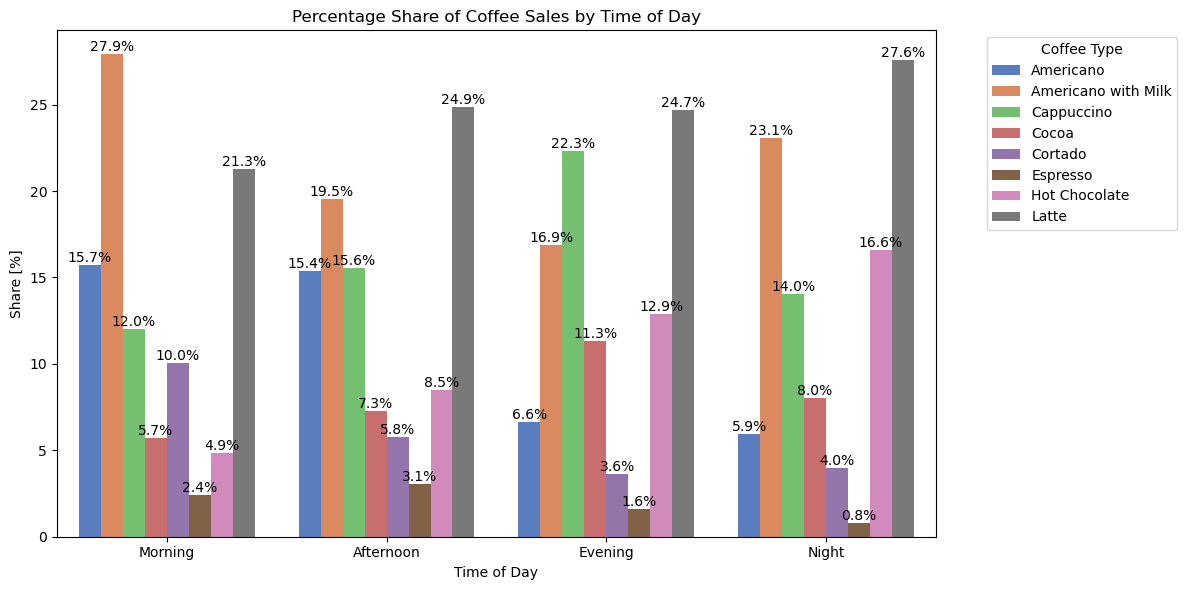

In [209]:
# 1️⃣ Aggregate: sum of revenue by time of day and coffee type
revenue_dist = coffee_df.groupby(["Time_of_Day", "coffee_name"])["money"].sum().reset_index()

# Calculate percentage share within each time of day
revenue_dist["percentage"] = revenue_dist.groupby("Time_of_Day")["money"].transform(
    lambda x: 100 * x / x.sum()
)

# 3️⃣ Set the order of time-of-day categories
order = ["Morning", "Afternoon", "Evening", "Night"]
revenue_dist["Time_of_Day"] = pd.Categorical(revenue_dist["Time_of_Day"], categories=order, ordered=True)

# 4️⃣ Plot the bar chart
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=revenue_dist,
    x="Time_of_Day",
    y="percentage",
    hue="coffee_name",
    palette="muted"
)

plt.title("Percentage Share of Coffee Sales by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Share [%]")
plt.xticks(rotation=0)

# 5️⃣ Add percentage labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=10, color="black")

plt.legend(title="Coffee Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


The most popular coffee is "Latte," except in the mornings, where "Americano with Milk" takes the lead. Meanwhile, "Cappuccino" is the second most popular coffee during evening hours. The least popular is plain "Espresso."

###  Brief Analysis of Revenue by Month

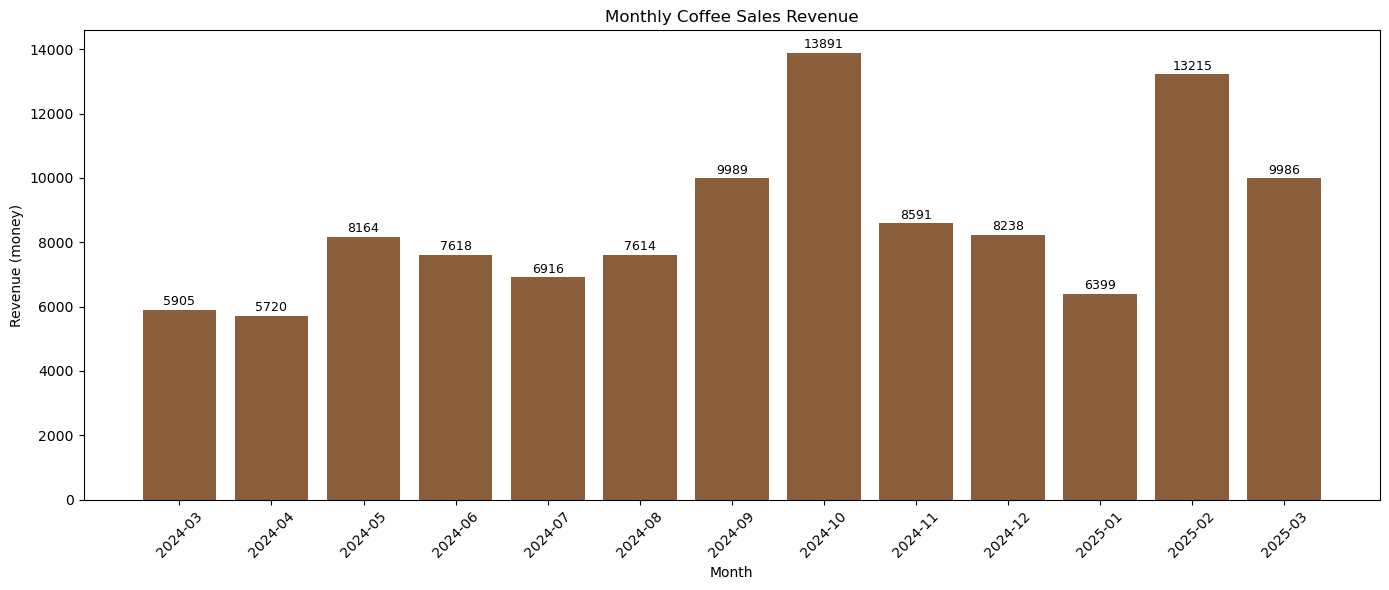

In [210]:
import matplotlib.pyplot as plt

# 1️⃣ Creted col Year-Month
coffee_df["YearMonth"] = coffee_df["Date Time"].dt.to_period("M")  # np. 2024-03, 2024-04, ...

# 2️⃣ Grup YearMonth
monthly_revenue = coffee_df.groupby("YearMonth")["money"].sum().reset_index()

# 3️⃣ Created barplot
plt.figure(figsize=(14,6))
bars = plt.bar(monthly_revenue["YearMonth"].astype(str), monthly_revenue["money"], color="#8B5E3C")

plt.title("Monthly Coffee Sales Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue (money)")
plt.xticks(rotation=45)

# 4️⃣ Adding values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f'{height:.0f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### The most profitable months are March and October 2024 and February 2025

# ☕ 3: Corelation Matrx

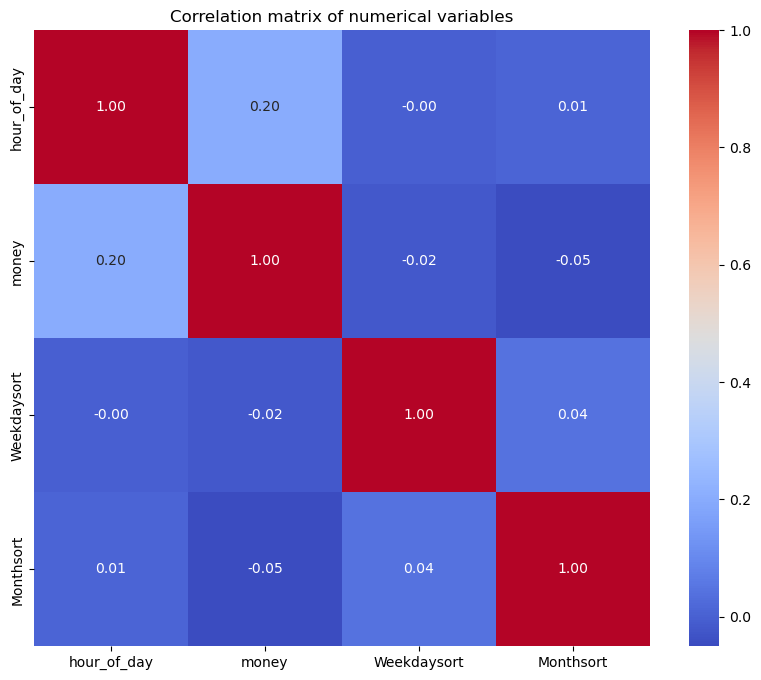

In [211]:
numeric_cols = coffee_df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_cols.corr()
corr_matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix of numerical variables")
plt.show()

### There is no significant correlation in the data

# ☕ 4: Outlier analysis will help us answer whether the data comes from the USA, or rather whether it matches what I would expect from US data


Outliers (days and number of coffees sold):
          Date  coffee_name
148 2024-07-30           24
197 2024-09-17           23
202 2024-09-22           24
221 2024-10-11           26
332 2025-02-03           25
334 2025-02-05           24
350 2025-02-21           23
371 2025-03-14           23


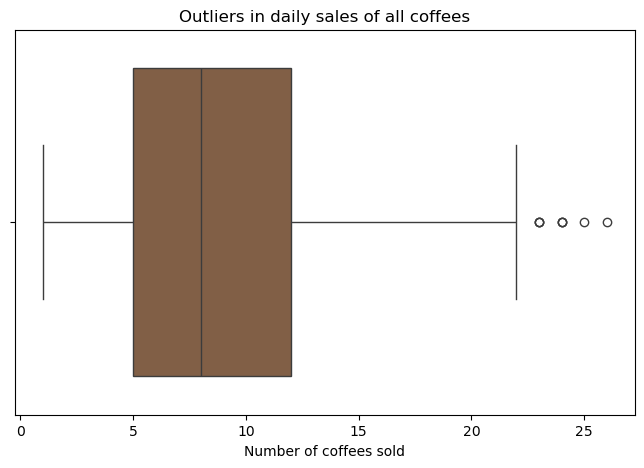

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ day sells of all coffees
daily_sales = coffee_df.groupby("Date")["coffee_name"].count().reset_index()
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])
daily_sales = daily_sales.sort_values("Date")

# 2️⃣ Calculating outliers using the IQR method
Q1 = daily_sales["coffee_name"].quantile(0.25)
Q3 = daily_sales["coffee_name"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = daily_sales[
    (daily_sales["coffee_name"] < lower_bound) |
    (daily_sales["coffee_name"] > upper_bound)
]

print("Outliers (days and number of coffees sold):")
print(outliers)

# 3️⃣ Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x=daily_sales["coffee_name"], color="#8B5E3C")
plt.title("Outliers in daily sales of all coffees")
plt.xlabel("Number of coffees sold")
plt.show()


American holidays / important days in this period

1. July 4, 2024 – Independence Day
→ Not present in outliers (July 4 = 2 coffees earlier), so holiday sales are not high in the data.

2. Labor Day 2024 – September 2 (first Monday of September)
→ September 17 and September 22 → do not match.

3. Columbus Day 2024 – October 14 (second Monday of October)
→ October 11 → somewhat close, but not exact.

4. Thanksgiving 2024 – November 28 (fourth Thursday of November)
→ Not present in outliers.

5. New Year – January 1, 2025
→ Not present in outliers.

6. Super Bowl 2025 – February 2, 2025
→ February 3 → close, but depends on the exact date of the game in 2025.

### The data does not match the typical pattern expected from the USA.
### Conclusion: The sales data likely does not originate from the USA.